<a href="https://colab.research.google.com/github/mohitkadwal/July-2025/blob/main/Tess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub
import os

# Use kagglehub and define correct dataset folder path
dataset_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

# Some kagglehub datasets have an inner directory like:
# /kaggle/working/kagglehub-datasets/ejlok1/toronto-emotional-speech-set-tess/TESS_Toronto_emotional_speech_set
# Let's find that correct subfolder:
for item in os.listdir(dataset_path):
    sub_path = os.path.join(dataset_path, item)
    if os.path.isdir(sub_path) and "TESS" in item:
        dataset_path = sub_path
        break

# Now extract labels and paths
paths = []
labels = []

for dir_name, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if filename.endswith('.wav'):
            full_path = os.path.join(dir_name, filename)
            paths.append(full_path)

            # Extract label from folder name
            emotion = os.path.basename(dir_name).split('_')[-1].lower()
            labels.append(emotion)

print("âœ… Dataset loaded")
print(f"ðŸ”¸ Total files: {len(paths)}")
print(f"ðŸ”¹ Unique emotions: {sorted(set(labels))}")


âœ… Dataset loaded
ðŸ”¸ Total files: 2800
ðŸ”¹ Unique emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'surprised']


In [ ]:
len(paths)

2800

In [ ]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [ ]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [ ]:
df = pd.DataFrame()
df['audio.paths'] = paths
df['labels'] = labels
df.head()

audio.paths labels
0  /kaggle/input/toronto-emotional-speech-set-tes...   fear
1  /kaggle/input/toronto-emotional-speech-set-tes...   fear
2  /kaggle/input/toronto-emotional-speech-set-tes...   fear
3  /kaggle/input/toronto-emotional-speech-set-tes...   fear
4  /kaggle/input/toronto-emotional-speech-set-tes...   fear

In [ ]:
df['labels'].value_counts()

labels
fear         400
angry        400
disgust      400
neutral      400
sad          400
happy        400
surprise     200
surprised    200
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

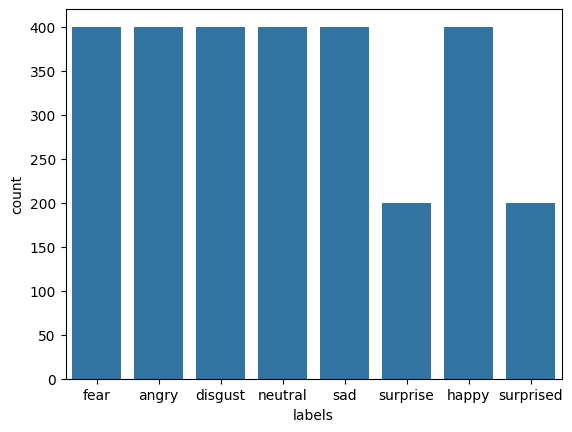

In [ ]:
sns.countplot(data=df, x='labels')

In [ ]:
def waveplot(data, sr, emotion):
  plt.figure(figsize=(10,4))
  plt.title(emotion, size=20)
  librosa.display.waveshow(data, sr=sr)
  plt.show()

def spectogram(data, sr, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  plt.figure(figsize=(11,4))
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

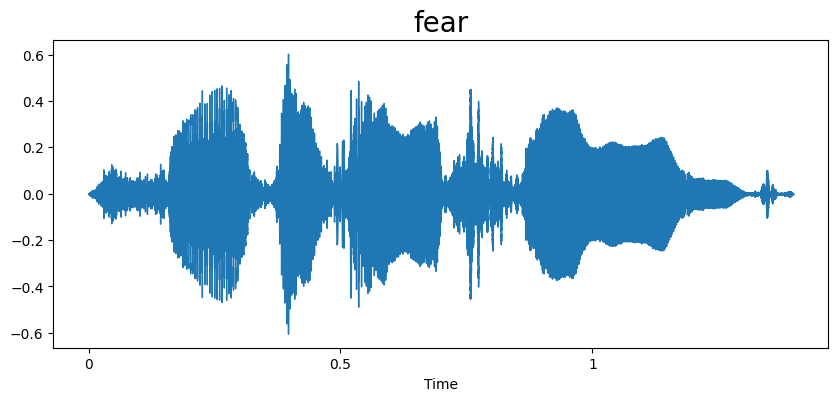

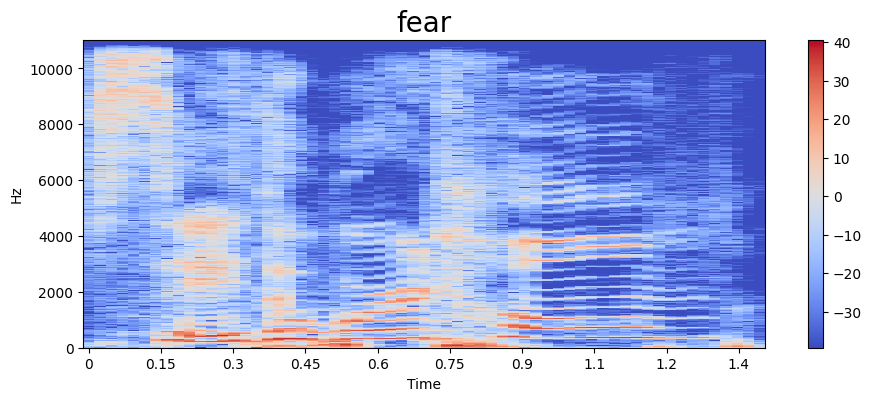

In [ ]:
emotion='fear'
path = np.array(df['audio.paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

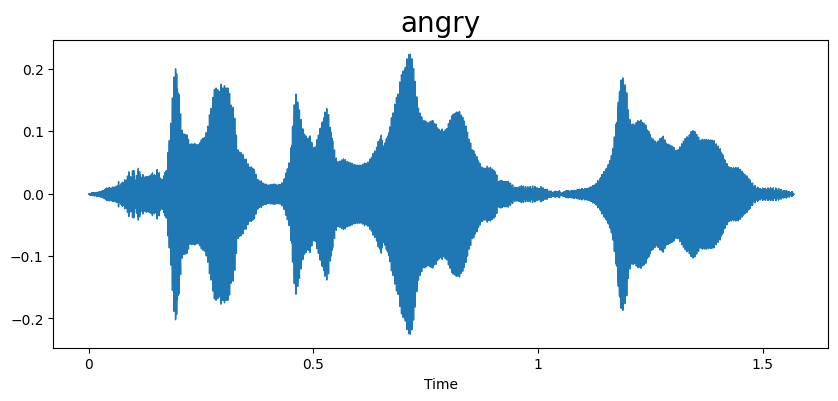

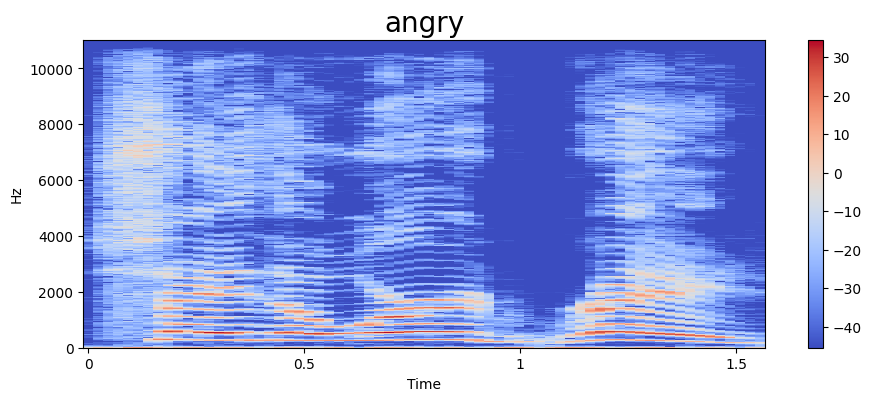

In [ ]:
emotion='angry'
path = np.array(df['audio.paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

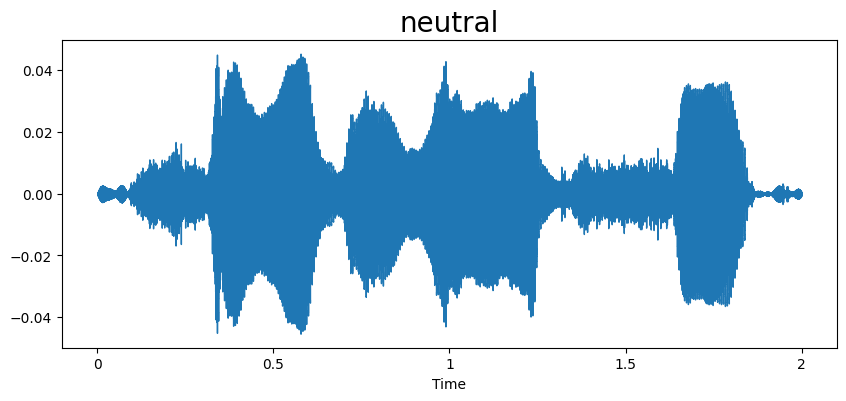

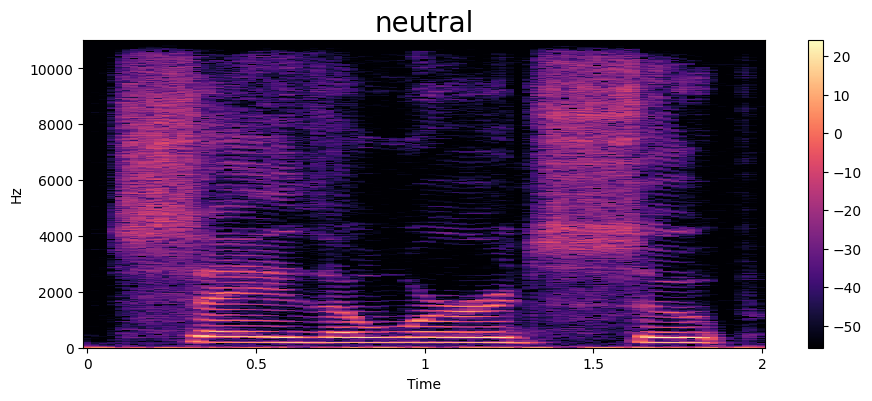

In [ ]:
emotion='neutral'
path = np.array(df['audio.paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

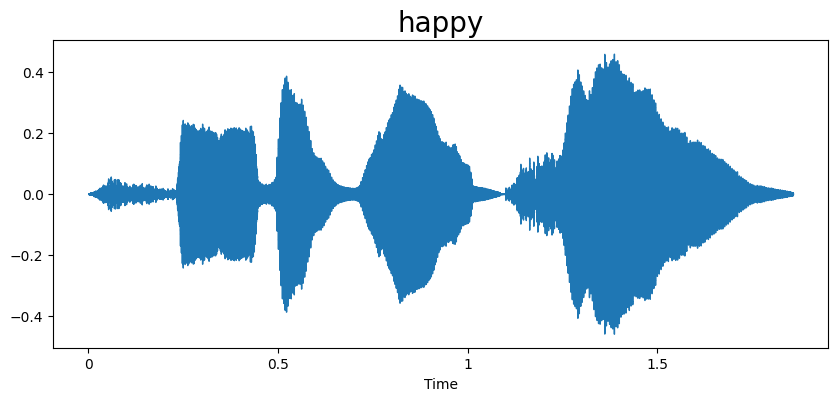

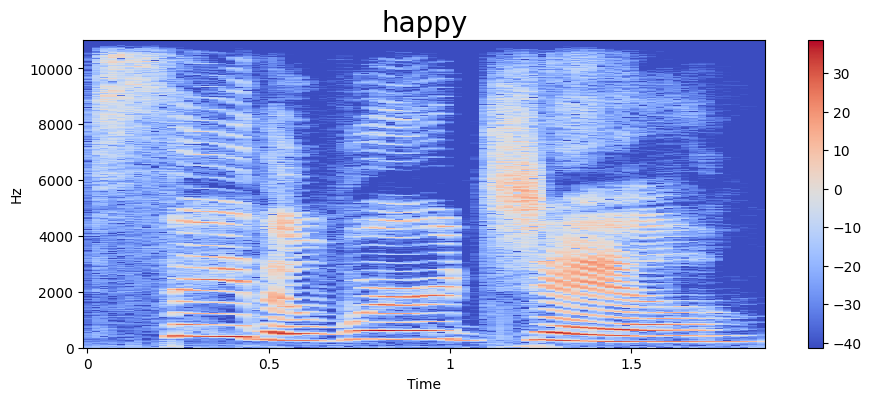

In [ ]:
emotion='happy'
path = np.array(df['audio.paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

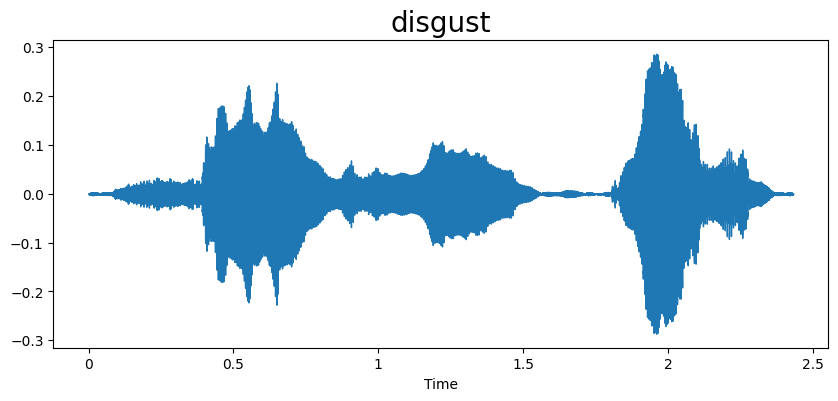

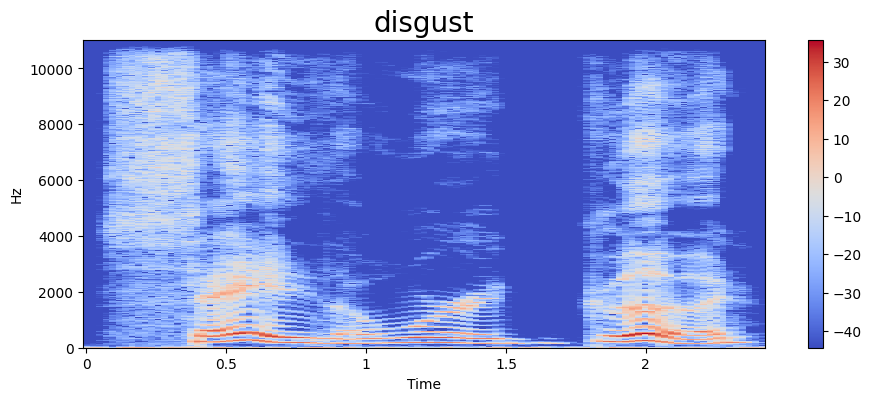

In [ ]:
emotion='disgust'
path = np.array(df['audio.paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

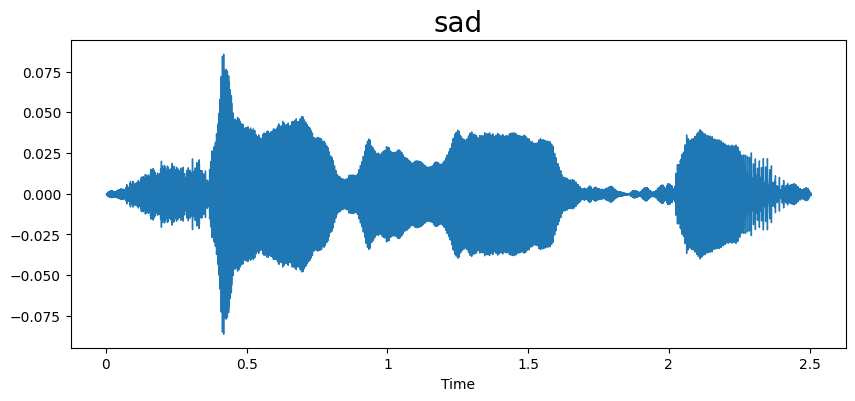

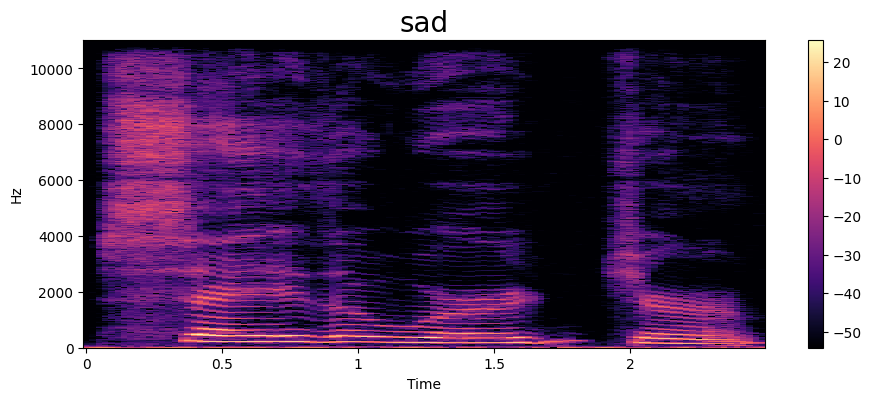

In [ ]:
emotion='sad'
path = np.array(df['audio.paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

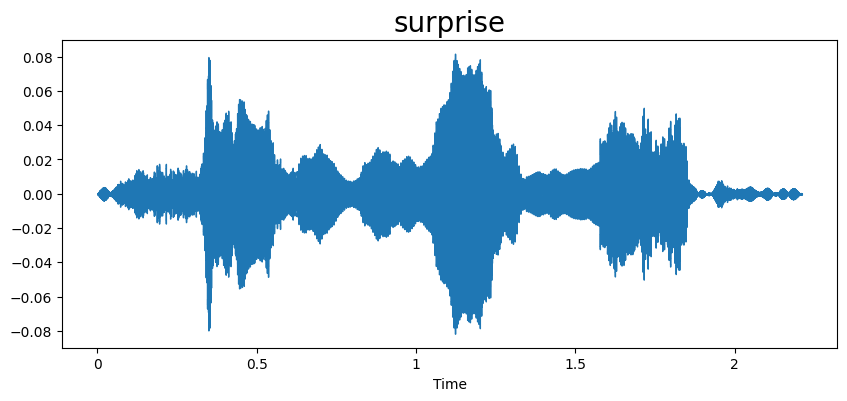

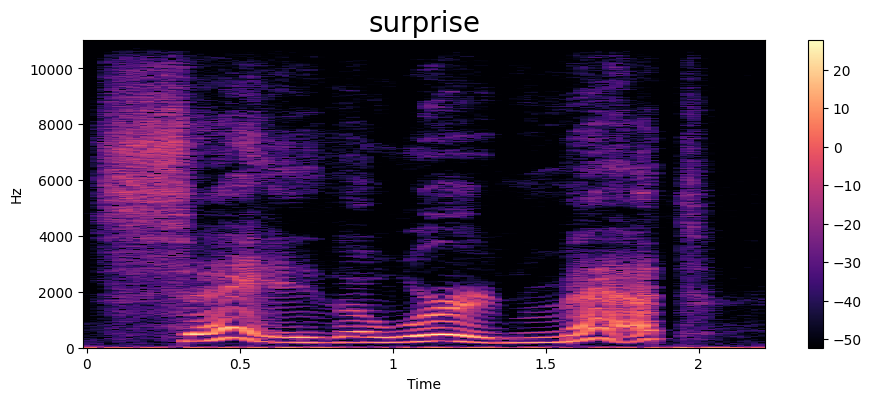

In [ ]:
emotion='surprise'
path = np.array(df['audio.paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion = 'ps'
# Check if the emotion exists in the DataFrame
if emotion in df['labels'].unique():
    path = np.array(df['audio.paths'][df['labels']==emotion])[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)
else:
    print(f"Emotion '{emotion}' not found in the dataset.")

Emotion 'ps' not found in the dataset.


In [ ]:

# Convert labels to integers (sorted for consistency)
unique_labels = sorted(df['labels'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)

In [ ]:
class SpeechEmotion(Dataset):
  def __init__(self, df, processor, max_length=16000):
    self.df = df
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    audio_path = self.df.iloc[idx]['audio.paths']
    label = self.df.iloc[idx]['labels']

    speech, sr = librosa.load(audio_path, sr=16000)

    if len(speech) > self.max_length:
        speech = speech[:self.max_length]
    elif len(speech) < self.max_length:
        speech = np.pad(speech,(0, self.max_length - len(speech)),'constant')

    # Process the audio data
    inputs = self.processor(speech, sampling_rate=sr, return_tensors="pt", padding=True, truncate=True, max_length=self.max_length)
    processed_speech = inputs.input_values.squeeze()

    return {'input_values': processed_speech, 'labels': torch.tensor(label, dtype=torch.long)}

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

# Use the emotion-finetuned feature extractor
processor = Wav2Vec2FeatureExtractor.from_pretrained('ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition')

# Load the emotion-finetuned classification model
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    'ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition',
    num_labels=len(label_map)
)

# Freeze Wav2Vec2 encoder layers to avoid overfitting
for param in model.wav2vec2.parameters():
    param.requires_grad = False


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', '

In [ ]:
train_dataset = SpeechEmotion(train_df, processor)
test_dataset = SpeechEmotion(test_df, processor)

In [ ]:
train_dataset[0]['input_values'].size()

torch.Size([16000])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.001,
    report_to=[] # Explicitly disable reporting to any integration
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

TrainOutput(global_step=2100, training_loss=0.9337957436697824, metrics={'train_runtime': 1643.2407, 'train_samples_per_second': 20.447, 'train_steps_per_second': 1.278, 'total_flos': 1.0183321645056e+18, 'train_loss': 0.9337957436697824, 'epoch': 15.0})

In [ ]:
# Evaluate on validation set
results = trainer.evaluate()
print("Validation Results:", results)

# Now calculate training (normal) accuracy manually
from sklearn.metrics import accuracy_score

# Get predictions on training set
train_predictions = trainer.predict(train_dataset)
train_preds = np.argmax(train_predictions.predictions, axis=1)
train_labels = train_predictions.label_ids

# Calculate accuracy
train_accuracy = accuracy_score(train_labels, train_preds)

print("Training Accuracy:", train_accuracy)


Validation Results: {'eval_loss': 0.610994279384613, 'eval_accuracy': 0.7946428571428571, 'eval_f1': 0.7764810997361035, 'eval_precision': 0.8054920753464925, 'eval_recall': 0.7946428571428571, 'eval_runtime': 12.5236, 'eval_samples_per_second': 44.715, 'eval_steps_per_second': 2.795, 'epoch': 15.0}
Training Accuracy: 0.7915178571428572
